In [1]:
import torch #should be installed by default in any colab notebook
import numpy as np
import matplotlib.pyplot as plt
import json
import os
import pandas as pd
from time import time
import plotly.express as px


#assert torch.cuda.is_available(), "GPU is not enabled"

# use gpu if available
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
from torch.utils.data import Dataset
from torchvision.io import read_image
from torch.utils.data import DataLoader

class ImageDataset(Dataset):
    def __init__(self, GT_file_path, images_dir_path):
        self.df_GTs = pd.DataFrame.from_dict(json.load(open(GT_file_path)))
        self.images_dir_path = images_dir_path
        self.len_data = len(self.df_GTs)

    def __len__(self):
        return self.len_data

    def __getitem__(self, idx):
        img_path = f"{self.images_dir_path}/IM_{self.df_GTs.iloc[idx,0]}_phiCR_{self.df_GTs.iloc[idx,1]}.png"
        image = read_image(img_path) #[1, 2X+1, 2X+1] torch tensor
        label = torch.Tensor([float(self.df_GTs.iloc[idx, 1])]).type(torch.float32) #[1] torch tensor of float32
        return image, label

# NON NOISY
---

In [3]:
#GT_file_path_train = f"/home/melanie/Desktop/Conical_Refraction_Polarimeter/OUTPUT/NON NOISY/GROUND_TRUTHS.json"
#images_dir_path_train =f"/home/melanie/Desktop/Conical_Refraction_Polarimeter/OUTPUT/NON NOISY/" 
GT_file_path_train = f"/home/oiangu/Hippocampus/Conical_Refraction_Polarimeter/OUTPUT/LIBRARIES_OF_THEORETICAL_D/Basler_like_R0_300x_w0_300x_Z_50x_64bit/IMAGE_LIBRARY/NON_NOISY/TRAIN/GROUND_TRUTHS.json"
images_dir_path_train =f"/home/oiangu/Hippocampus/Conical_Refraction_Polarimeter/OUTPUT/LIBRARIES_OF_THEORETICAL_D/Basler_like_R0_300x_w0_300x_Z_50x_64bit/IMAGE_LIBRARY/NON_NOISY/TRAIN/" 

training_data = ImageDataset(GT_file_path_train, images_dir_path_train)

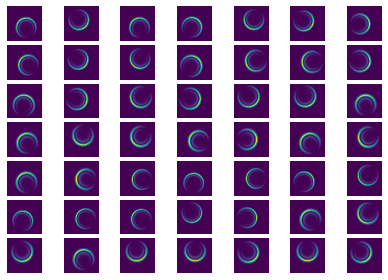

In [4]:
fig, ax_array = plt.subplots(7, 7)
axes = ax_array.flatten()
for i, ax in enumerate(axes):
    im, lab = training_data[i]
    ax.imshow(im[0])
plt.setp(axes, xticks=[], yticks=[], frame_on=False)
plt.tight_layout(h_pad=0.4, w_pad=0.0001)

Prepare a smaller subset all in RAM to perfrom PCA and UMAP on its samples!

In [5]:
num_images = 500
random_indices = np.random.choice(range(len(training_data)), num_images, replace=False)
#random_indices = np.random.choice(range(2850), num_images, replace=False)
X21 = training_data[0][0].shape[1]
x = np.zeros( (num_images, X21**2), dtype=np.float32)
y = np.zeros((num_images), dtype=np.float64)

for j,idx in enumerate(random_indices):
    im, lab = training_data[idx]
    x[j, :] = im[0].flatten()
    y[j] = lab   

df = pd.DataFrame({'y':y})
df['phiCR'] = df["y"].astype(str)

pip install umap-learn
pip install bokeh


# a) Test with PCA

In [6]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
df['principal component 1'] = principalDf['principal component 1']
df['principal component 2'] = principalDf['principal component 2']

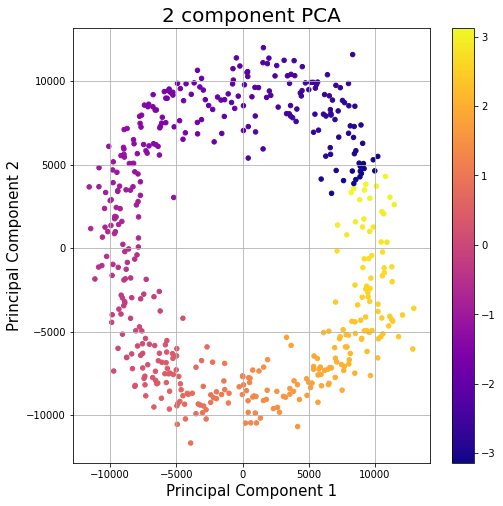

In [7]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

points = ax.scatter(df['principal component 1']
               , df['principal component 2']
               , s = 20, c=y, cmap="plasma"
              )
fig.colorbar(points)

#ax.legend(targets)
ax.grid()

In [9]:
from io import BytesIO
from PIL import Image
import base64
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, LinearColorMapper
from bokeh.palettes import Spectral10

output_notebook()

def embeddable_image(data):
    img_data = data.values.reshape(X21,X21).astype(np.uint8)
    image = Image.fromarray(img_data, mode='L').resize((64, 64), Image.BICUBIC)
    buffer = BytesIO()
    image.save(buffer, format='png')
    for_encoding = buffer.getvalue()
    return 'data:image/png;base64,' + base64.b64encode(for_encoding).decode()

df['image'] = pd.DataFrame(data=x, columns=list(range(x.shape[1]))).apply(embeddable_image, axis=1)

datasource = ColumnDataSource(df)
color_mapping = LinearColorMapper(
    palette='Magma256',
    low=y.min(),
    high=y.max()
)

plot_figure = figure(
    title='PCA projection of the CR dataset',
    plot_width=800,
    plot_height=800,
    tools=('pan, wheel_zoom, reset')
)

plot_figure.add_tools(HoverTool(tooltips="""
<div>
    <div>
        <img src='@image' style='float: left; margin: 5px 5px 5px 5px'/>
    </div>
    <div>
        <span style='font-size: 16px; color: #224499'>phiCR:</span>
        <span style='font-size: 18px'>@phiCR</span>
    </div>
</div>
"""))

plot_figure.circle(
    'principal component 1',
    'principal component 2',
    source=datasource,
    color=dict(field='phiCR', transform=color_mapping),
    line_alpha=0.6,
    fill_alpha=0.6,
    size=7
)
show(plot_figure)

Loading BokehJS ...

In [84]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)

principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2', 'principal component 3'])
df['principal component 1'] = principalDf['principal component 1']
df['principal component 2'] = principalDf['principal component 2']
df['principal component 3'] = principalDf['principal component 3']

In [85]:
fig=px.scatter_3d(df, x="principal component 1", y="principal component 2", z="principal component 3", color="y")
fig.update_traces(marker={"size":3})
fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.show()

# b) Test with UMAP

In [12]:
from umap import UMAP

umap_reducer = UMAP(n_components=2, min_dist=0.1, n_neighbors=500, metric='euclidean')
principalComponents = umap_reducer.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['umap_1', 'umap_2'])
df['umap_1'] = principalDf['umap_1']
df['umap_2'] = principalDf['umap_2']

2022-01-19 16:02:52.081852: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
/home/oiangu/anaconda3/lib/python3.8/site-packages/umap/umap_.py:2344: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


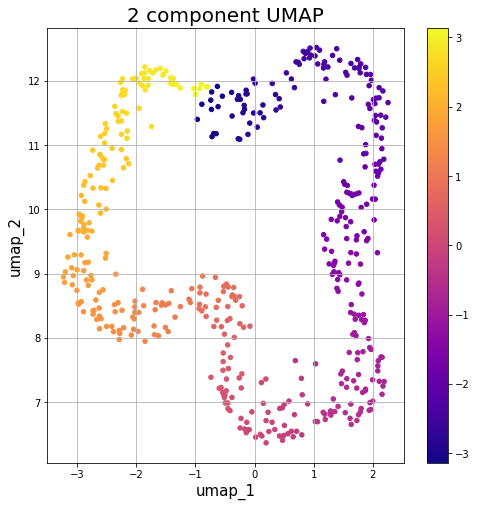

In [13]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('umap_1', fontsize = 15)
ax.set_ylabel('umap_2', fontsize = 15)
ax.set_title('2 component UMAP', fontsize = 20)

points = ax.scatter(df['umap_1']
               , df['umap_2']
               , s = 20, c=y, cmap="plasma"
              )
fig.colorbar(points)

ax.grid()

In [17]:
from io import BytesIO
from PIL import Image
import base64
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, LinearColorMapper
from bokeh.palettes import Spectral10

output_notebook()

def embeddable_image(data):
    img_data = data.values.reshape(X21,X21).astype(np.uint8)
    image = Image.fromarray(img_data, mode='L').resize((64, 64), Image.BICUBIC)
    buffer = BytesIO()
    image.save(buffer, format='png')
    for_encoding = buffer.getvalue()
    return 'data:image/png;base64,' + base64.b64encode(for_encoding).decode()

df['image'] = pd.DataFrame(data=x, columns=list(range(x.shape[1]))).apply(embeddable_image, axis=1)


datasource = ColumnDataSource(df)
color_mapping = LinearColorMapper(
    palette='Magma256',
    low=y.min(),
    high=y.max()
)

plot_figure = figure(
    title='UMAP projection of the CR dataset',
    plot_width=800,
    plot_height=800,
    tools=('pan, wheel_zoom, reset')
)

plot_figure.add_tools(HoverTool(tooltips="""
<div>
    <div>
        <img src='@image' style='float: left; margin: 5px 5px 5px 5px'/>
    </div>
    <div>
        <span style='font-size: 16px; color: #224499'>phiCR:</span>
        <span style='font-size: 18px'>@phiCR</span>
    </div>
</div>
"""))

plot_figure.circle(
    'umap_1',
    'umap_2',
    source=datasource,
    color=dict(field='phiCR', transform=color_mapping),
    line_alpha=0.6,
    fill_alpha=0.6,
    size=7
)
show(plot_figure)

Loading BokehJS ...

In [15]:
df

umap_1     umap_2  principal component 1  principal component 2  \
0    0.897762  12.457628           -7856.016113           -3901.604248   
1    2.025577  11.387242           -9742.861328           -1730.108521   
2    1.643778  11.734732          -10006.349609           -2789.202637   
3   -0.455288   7.892110            5340.362305            5777.729980   
4   -1.505080   8.513991            8923.299805            1505.243774   
..        ...        ...                    ...                    ...   
495  1.736078   7.662982           -3064.556641            9072.562500   
496 -1.876080   8.501334           10261.807617            -370.049225   
497  0.193799   6.714679            2636.710205            8621.479492   
498 -1.667042   8.550556            7336.749512             839.329224   
499  1.297150   9.845415           -7979.755371            2640.297852   

            y                 phiCR  \
0   -2.407679   -2.4076788425445557   
1   -2.102462   -2.1024622917175293   
2   -2.200836    -2.200835943222046   
3    0.483704    0.4837035536766052   
4    1.134495    1.1344949007034302   
..        ...                   ...   
495 -0.869478   -0.8694776296615601   
496  1.334952    1.3349521160125732   
497 -0.045984  -0.04598421975970268   
498  1.196056    1.1960563659667969   
499 -1.623703   -1.6237033605575562   

                                                 image  
0    data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...  
1    data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...  
2    data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...  
3    data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...  
4    data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...  
..                                                 ...  
495  data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...  
496  data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...  
497  data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...  
498  data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...  
499  data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...  

[500 rows x 7 columns]

In [92]:
from umap import UMAP

umap_reducer = UMAP(n_components=3, min_dist=0.1, n_neighbors=300, metric='hamming') #euclidean, canberra, cosine, manhattan, braycurtis, mahalanobis, hamming
principalComponents = umap_reducer.fit_transform(x, y=y)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['umap_1', 'umap_2', 'umap_3'])
df['umap_1'] = principalDf['umap_1']
df['umap_2'] = principalDf['umap_2']
df['umap_3'] = principalDf['umap_3']

/home/oiangu/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning:

gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable



In [93]:
fig=px.scatter_3d(df, x="umap_1", y="umap_2", z="umap_3", color="y")
fig.update_traces(marker={"size":3})
fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.show()

 # NOISY
 ---
 

In [10]:
GT_file_path_train = f"/home/oiangu/Desktop/Conical_Refraction_Polarimeter/OUTPUT/NOISY/TRAIN/GROUND_TRUTHS.json"
images_dir_path_train =f"/home/oiangu/Desktop/Conical_Refraction_Polarimeter/OUTPUT/NOISY/TRAIN/" 

training_data = ImageDataset(GT_file_path_train, images_dir_path_train)

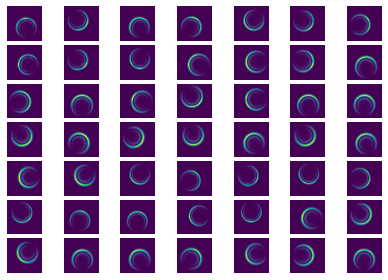

In [11]:
fig, ax_array = plt.subplots(7, 7)
axes = ax_array.flatten()
for i, ax in enumerate(axes):
    im, lab = training_data[i]
    ax.imshow(im[0])
plt.setp(axes, xticks=[], yticks=[], frame_on=False)
plt.tight_layout(h_pad=0.4, w_pad=0.0001)

Prepare a smaller subset all in RAM to perfrom PCA and UMAP on its samples!

In [12]:
num_images = 500
random_indices = np.random.choice(range(len(training_data)), num_images, replace=False)
#random_indices = np.random.choice(range(2850), num_images, replace=False)
X21 = training_data[0][0].shape[1]
x = np.zeros( (num_images, X21**2), dtype=np.float32)
y = np.zeros((num_images), dtype=np.float64)

for j,idx in enumerate(random_indices):
    im, lab = training_data[idx]
    x[j, :] = im[0].flatten()
    y[j] = lab   

df = pd.DataFrame({'y':y})
df['phiCR'] = df["y"].astype(str)

pip install umap-learn
pip install bokeh


# a) Test with PCA

In [39]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
df['principal component 1'] = principalDf['principal component 1']
df['principal component 2'] = principalDf['principal component 2']

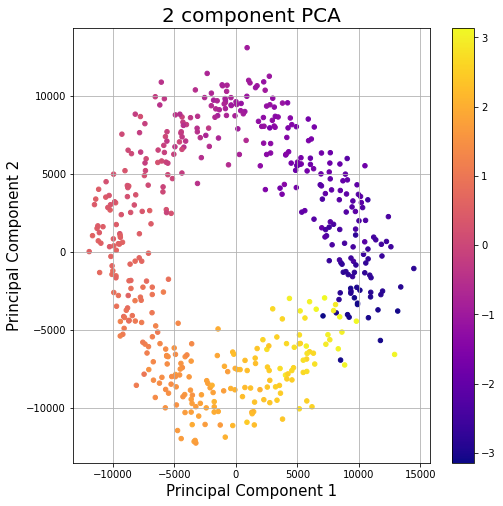

In [28]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

points = ax.scatter(df['principal component 1']
               , df['principal component 2']
               , s = 20, c=y, cmap="plasma"
              )
fig.colorbar(points)

#ax.legend(targets)
ax.grid()

In [29]:
from io import BytesIO
from PIL import Image
import base64
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, LinearColorMapper
from bokeh.palettes import Spectral10

output_notebook()

def embeddable_image(data):
    img_data = data.values.reshape(X21,X21).astype(np.uint8)
    image = Image.fromarray(img_data, mode='L').resize((64, 64), Image.BICUBIC)
    buffer = BytesIO()
    image.save(buffer, format='png')
    for_encoding = buffer.getvalue()
    return 'data:image/png;base64,' + base64.b64encode(for_encoding).decode()

df['image'] = pd.DataFrame(data=x, columns=list(range(x.shape[1]))).apply(embeddable_image, axis=1)

datasource = ColumnDataSource(df)
color_mapping = LinearColorMapper(
    palette='Magma256',
    low=y.min(),
    high=y.max()
)

plot_figure = figure(
    title='PCA projection of the CR dataset',
    plot_width=800,
    plot_height=800,
    tools=('pan, wheel_zoom, reset')
)

plot_figure.add_tools(HoverTool(tooltips="""
<div>
    <div>
        <img src='@image' style='float: left; margin: 5px 5px 5px 5px'/>
    </div>
    <div>
        <span style='font-size: 16px; color: #224499'>phiCR:</span>
        <span style='font-size: 18px'>@phiCR</span>
    </div>
</div>
"""))

plot_figure.circle(
    'principal component 1',
    'principal component 2',
    source=datasource,
    color=dict(field='phiCR', transform=color_mapping),
    line_alpha=0.6,
    fill_alpha=0.6,
    size=7
)
show(plot_figure)

Loading BokehJS ...

In [77]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)

principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2', 'principal component 3'])
df['principal component 1'] = principalDf['principal component 1']
df['principal component 2'] = principalDf['principal component 2']
df['principal component 3'] = principalDf['principal component 3']

In [78]:
fig=px.scatter_3d(df, x="principal component 1", y="principal component 2", z="principal component 3", color="y")
fig.update_traces(marker={"size":3})
fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.show()

# b) Test with UMAP

https://umap-learn.readthedocs.io/en/latest/parameters.html#metric

In [66]:
from umap import UMAP

umap_reducer = UMAP(n_components=2, min_dist=0.1, n_neighbors=300, metric='hamming') #euclidean, canberra, cosine, manhattan, braycurtis, mahalanobis, hamming
principalComponents = umap_reducer.fit_transform(x, y=y)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['umap_1', 'umap_2'])
df['umap_1'] = principalDf['umap_1']
df['umap_2'] = principalDf['umap_2']

/home/oiangu/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  warn(


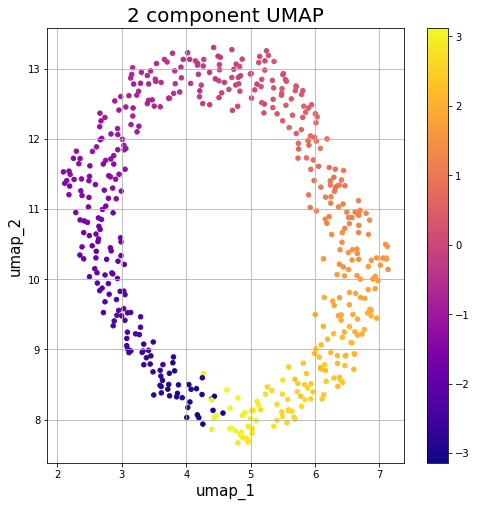

In [67]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('umap_1', fontsize = 15)
ax.set_ylabel('umap_2', fontsize = 15)
ax.set_title('2 component UMAP', fontsize = 20)

points = ax.scatter(df['umap_1']
               , df['umap_2']
               , s = 20, c=y, cmap="plasma"
              )
fig.colorbar(points)

ax.grid()

In [58]:
from io import BytesIO
from PIL import Image
import base64
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, LinearColorMapper
from bokeh.palettes import Spectral10

output_notebook()

def embeddable_image(data):
    img_data = data.values.reshape(X21,X21).astype(np.uint8)
    image = Image.fromarray(img_data, mode='L').resize((64, 64), Image.BICUBIC)
    buffer = BytesIO()
    image.save(buffer, format='png')
    for_encoding = buffer.getvalue()
    return 'data:image/png;base64,' + base64.b64encode(for_encoding).decode()

df['image'] = pd.DataFrame(data=x, columns=list(range(x.shape[1]))).apply(embeddable_image, axis=1)


datasource = ColumnDataSource(df)
color_mapping = LinearColorMapper(
    palette='Magma256',
    low=y.min(),
    high=y.max()
)

plot_figure = figure(
    title='UMAP projection of the CR dataset',
    plot_width=800,
    plot_height=800,
    tools=('pan, wheel_zoom, reset')
)

plot_figure.add_tools(HoverTool(tooltips="""
<div>
    <div>
        <img src='@image' style='float: left; margin: 5px 5px 5px 5px'/>
    </div>
    <div>
        <span style='font-size: 16px; color: #224499'>Digit:</span>
        <span style='font-size: 18px'>@phiCR</span>
    </div>
</div>
"""))

plot_figure.circle(
    'umap_1',
    'umap_2',
    source=datasource,
    color=dict(field='phiCR', transform=color_mapping),
    line_alpha=0.6,
    fill_alpha=0.6,
    size=7
)
show(plot_figure)

Loading BokehJS ...

In [59]:
df

y                phiCR    umap_1     umap_2  \
0    1.372974   1.3729742765426636  4.465486   4.904000   
1    1.550526     1.55052649974823  4.735268   4.367092   
2    3.132269   3.1322686672210693  8.356728   7.804432   
3    0.751178   0.7511776089668274  2.958910   6.249622   
4    3.018608    3.018608331680298  8.577343   8.032731   
..        ...                  ...       ...        ...   
495  0.862470   0.8624702095985413  2.694986   5.881058   
496  2.680905    2.680905342102051  6.996958   7.089549   
497  2.540436    2.540436029434204  7.223073   6.230521   
498 -1.544695   -1.544695496559143  3.633017  10.276340   
499 -0.350392  -0.3503921627998352  0.517520   8.821031   

                                                 image  
0    data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...  
1    data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...  
2    data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...  
3    data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...  
4    data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...  
..                                                 ...  
495  data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...  
496  data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...  
497  data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...  
498  data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...  
499  data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...  

[500 rows x 5 columns]

In [74]:
from umap import UMAP

umap_reducer = UMAP(n_components=3, min_dist=0.1, n_neighbors=300, metric='hamming') #euclidean, canberra, cosine, manhattan, braycurtis, mahalanobis, hamming
principalComponents = umap_reducer.fit_transform(x, y=y)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['umap_1', 'umap_2', 'umap_3'])
df['umap_1'] = principalDf['umap_1']
df['umap_2'] = principalDf['umap_2']
df['umap_3'] = principalDf['umap_3']

/home/oiangu/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning:

gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable



In [76]:
fig=px.scatter_3d(df, x="umap_1", y="umap_2", z="umap_3", color="y")
fig.update_traces(marker={"size":3})
fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.show()

# INVERSE TRANSFORM TEST

In [14]:
from umap import UMAP

umap_reducer = UMAP(n_components=2, min_dist=0.2, n_neighbors=300, metric='euclidean') #euclidean, canberra, cosine, manhattan, braycurtis, mahalanobis, hamming
mapper = umap_reducer.fit(x)
#data=pd.DataFrame(mapper.embedding_, columns=["umap_1", "umap_2"])
df["umap_1"]=mapper.embedding_[:,0]
df["umap_2"]=mapper.embedding_[:,1]

In [15]:
fig=px.scatter(df, x="umap_1", y="umap_2", color="y")
fig.update_traces(marker={"size":3})
fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.show()

In [ ]:
min_rad=1.8
max_rad=4
center_x=2.6
center_y=3.6
Ntheta = 10
Nr = 5

test_pts = np.array([[center_x+R*np.cos(th), center_y+R*np.sin(th)]
                     for R in np.linspace(min_rad, max_rad, Nr) for th in np.linspace(-np.pi, np.pi-0.1, Ntheta)])
inv_transformed_points = mapper.inverse_transform(test_pts)

In [ ]:
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable
# Set up the grid
fig = plt.figure(figsize=(12,6))
gs = GridSpec(Nr, 3+Ntheta, fig)
scatter_ax = fig.add_subplot(gs[:, :3])
newCR_axes = np.zeros((Nr, Ntheta), dtype=object)
for i in range(Nr):
    for j in range(Ntheta):
        newCR_axes[i, j] = fig.add_subplot(gs[i, 3 + j])

# Use umap.plot to plot to the major axis
# umap.plot.points(mapper, labels=labels, ax=scatter_ax)
points=scatter_ax.scatter(mapper.embedding_[:, 0], mapper.embedding_[:, 1],
                   c=y.astype(np.int32), cmap='Spectral', s=5)
#scatter_ax.set(xticks=[], yticks=[])
divider = make_axes_locatable(scatter_ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(points, cax=cax, orientation='vertical')

# Plot the locations of the text points
scatter_ax.scatter(test_pts[:, 0], test_pts[:, 1], marker='x', c='k', s=15)


# Plot each of the generated digit images
for i in range(Nr):
    for j in range(Ntheta):
        newCR_axes[i, j].imshow(inv_transformed_points[i*Ntheta + j].reshape(X21, X21))
        newCR_axes[i, j].set(xticks=[], yticks=[])
print("Same row same radious, same column same angle")

In [ ]:
from io import BytesIO
from PIL import Image
import base64
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, LinearColorMapper
from bokeh.palettes import Spectral10

output_notebook()

def embeddable_image(data):
    img_data = data.values.reshape(X21,X21).astype(np.uint8)
    image = Image.fromarray(img_data, mode='L').resize((64, 64), Image.BICUBIC)
    buffer = BytesIO()
    image.save(buffer, format='png')
    for_encoding = buffer.getvalue()
    return 'data:image/png;base64,' + base64.b64encode(for_encoding).decode()

df['image'] = pd.DataFrame(data=x, columns=list(range(x.shape[1]))).apply(embeddable_image, axis=1)


datasource = ColumnDataSource(df)
color_mapping = LinearColorMapper(
    palette='Magma256',
    low=y.min(),
    high=y.max()
)

plot_figure = figure(
    title='UMAP projection of the CR dataset',
    plot_width=800,
    plot_height=800,
    tools=('pan, wheel_zoom, reset')
)

plot_figure.add_tools(HoverTool(tooltips="""
<div>
    <div>
        <img src='@image' style='float: left; margin: 5px 5px 5px 5px'/>
    </div>
    <div>
        <span style='font-size: 16px; color: #224499'>Digit:</span>
        <span style='font-size: 18px'>@phiCR</span>
    </div>
</div>
"""))

plot_figure.circle(
    'umap_1',
    'umap_2',
    source=datasource,
    color=dict(field='phiCR', transform=color_mapping),
    line_alpha=0.6,
    fill_alpha=0.6,
    size=7
)
show(plot_figure)